In [2]:
# 라이브러리 호출
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
LANGUAGE_LIST = ['chinese', 'japanese', 'thai', 'vietnamese']


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

path_lists = glob.glob(f"../data/*_receipt/ufo/train.json")

data = {}
data['images'] = {}
for path in path_lists:    
    json_data = read_json(path)
    images = list(json_data['images'].items())
    data['images'].update(dict(images))

print(f"Total number of images: {len(data['images'])}")

path_lists_100 = glob.glob(f"output_train_100.json")

data_train100 = {}
data_train100['images'] = {}
for path in path_lists_100:
    json_data = read_json(path)
    images = list(json_data['images'].items())
    data_train100['images'].update(dict(images))

print(f"Total number of images: {len(data_train100['images'])}")

Total number of images: 400
Total number of images: 400


In [5]:
keys_list = sorted(list(data['images'].keys()))
ja_keys_list = list()
zh_keys_list = list()
th_keys_list = list()
vi_keys_list = list()

for key in keys_list:
    if key.split('.')[1] == 'ja':
        ja_keys_list.append(key)
    elif key.split('.')[1] == 'zh':
        zh_keys_list.append(key)
    elif key.split('.')[1] == 'th':
        th_keys_list.append(key)
    elif key.split('.')[1] == 'vi':
        vi_keys_list.append(key)
t_key_list = [sorted(ja_keys_list),sorted(zh_keys_list),sorted(th_keys_list),sorted(vi_keys_list)]
for lan in t_key_list:
    print(len(lan))

100
100
100
100


In [6]:
len(t_key_list[0])

100

In [7]:
def get_box_angle(box):
    # 박스의 긴 변 방향을 찾습니다
    coords = np.array(box.exterior.coords)
    edges = np.diff(coords, axis=0)
    longest_edge = edges[np.argmax(np.sum(edges**2, axis=1))]
    angle = np.arctan2(longest_edge[1], longest_edge[0])
    return angle

def angle_difference(box1, box2):
    angle1 = get_box_angle(box1)
    angle2 = get_box_angle(box2)
    diff = angle2 - angle1
    # 각도 차이를 -pi에서 pi 사이로 정규화합니다
    return (diff + np.pi) % (2 * np.pi) - np.pi

def rotated_boxes_iou(box1, box2):
    poly1 = Polygon(box1)
    poly2 = Polygon(box2)    
    if not poly1.is_valid:
        poly1 = poly1.buffer(0)
    if not poly2.is_valid:
        poly2 = poly2.buffer(0)    
    inter_area = poly1.intersection(poly2).area    
    union_area = poly1.area + poly2.area - inter_area    
    iou = inter_area / union_area if union_area > 0 else 0    
    return iou

# 데이터 저장
iou_data = {}
def store_data(language, image, box, box2, iou, angle_diff):
    if language not in data:
        data[language] = {}
    if image not in data[language]:
        data[language][image] = {}
    data[language][image][box] = {'ybox':box2, 'iou': iou, 'angle_diff': angle_diff}

def get_data(language, image, box):
    return data[language][image][box]

# 모든 나라
for lang in t_key_list:
    country = lang[0].split('.')[1]
    # 나라별 이미지
    for li in tqdm(lang):
        # 이미지별 박스
        for p1 in data['images'][li]['words']:
            max = 0 
            mp2 = None
            box1 = data['images'][li]['words'][p1]['points']
            for p2 in data_train100['images'][li]['words']:
                box2 = data_train100['images'][li]['words'][p2]['points']
                iou = rotated_boxes_iou(box1, box2)
                if max < iou:
                    max = iou
                    mp2 = p2
            angle_diff = None
            if not mp2 == None: 
                box2 = data_train100['images'][li]['words'][mp2]['points']
                angle_diff = angle_difference(Polygon(box1), Polygon(box2))
            store_data(country,li,p1,mp2,max,angle_diff)
                       



# store_data('english', 'image001.jpg', 'box1', 0.85, 15.5)
# store_data('english', 'image001.jpg', 'box2', 0.92, 5.2)
# store_data('french', 'image002.jpg', 'box1', 0.78, 30.1)

# print(get_data('english', 'image001.jpg', 'box1'))

100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


In [11]:
iou_list = []
precision_list = []
not_found_list = []
used_ybox_list = []
for lang in t_key_list:
    country = lang[0].split('.')[1]
    # 나라별 이미지
    sumiou = 0
    count = 0
    tcount = 0 
    ycount=0
    Nount = 0
    totalboxcount = 0
    usedboxcount = 0
    for li in lang:
        # 이미지별 박스
        imge = np.zeros(len(data_train100['images'][li]['words']))
        totalboxcount +=len(data_train100['images'][li]['words'])
        for p1 in data['images'][li]['words']:
            ycount += len(data_train100['images'][li])
            temp =  get_data(country, li, p1)
            iou = temp['iou']
            sumiou += iou
            count += 1
            if iou > 0.5:
                tcount +=1
            if temp['ybox'] == None:
                Nount +=1
            else:
                imge[int(temp['ybox'])] = 1
        usedboxcount +=sum(imge)
        #print(f'{(len(imge) - sum(imge))/count :.4f}')
    iou_list.append(sumiou/count)
    precision_list.append(tcount/count)
    not_found_list.append(Nount/count)
    used_ybox_list.append(usedboxcount/totalboxcount)
    print(f'{country} : IoU {sumiou/count:.4f}, precision: {tcount/count:.4f}, not found: {Nount/count:.4f}, used ybox:{usedboxcount/totalboxcount: 0.4f} ')
 


ja : IoU 0.7288, precision: 0.8676, not found: 0.0109, used ybox: 0.8532 
zh : IoU 0.7388, precision: 0.8875, not found: 0.0024, used ybox: 0.7593 
th : IoU 0.7114, precision: 0.8612, not found: 0.0083, used ybox: 0.8391 
vi : IoU 0.7676, precision: 0.9084, not found: 0.0043, used ybox: 0.8612 


Text(0.5, 0.98, 'Comparison of Metrics Across Countries')

Text(0.5, 1.0, 'IoU')

(0.0, 0.8443307711290062)

Text(0.0, 0.7288174810376974, '0.7288')

Text(1.0, 0.7388189146417969, '0.7388')

Text(2.0, 0.7114141911881052, '0.7114')

Text(3.0, 0.7675734282990965, '0.7676')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Precision')

(0.0, 0.999266379964584)

Text(0.0, 0.8676177836761778, '0.8676')

Text(1.0, 0.8875400438374642, '0.8875')

Text(2.0, 0.8612472766884531, '0.8612')

Text(3.0, 0.9084239817859854, '0.9084')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Not Found')

(0.0, 0.012043795620437957)

Text(0.0, 0.010948905109489052, '0.0109')

Text(1.0, 0.0023604788399932556, '0.0024')

Text(2.0, 0.008306100217864924, '0.0083')

Text(3.0, 0.0043005312420946115, '0.0043')

Text(0, 0.5, 'Value')

Text(0.5, 1.0, 'Used YBox')

(0.0, 0.9473180935305544)

Text(0.0, 0.8531691746466028, '0.8532')

Text(1.0, 0.759344262295082, '0.7593')

Text(2.0, 0.8390997246498264, '0.8391')

Text(3.0, 0.8611982668459585, '0.8612')

Text(0, 0.5, 'Value')

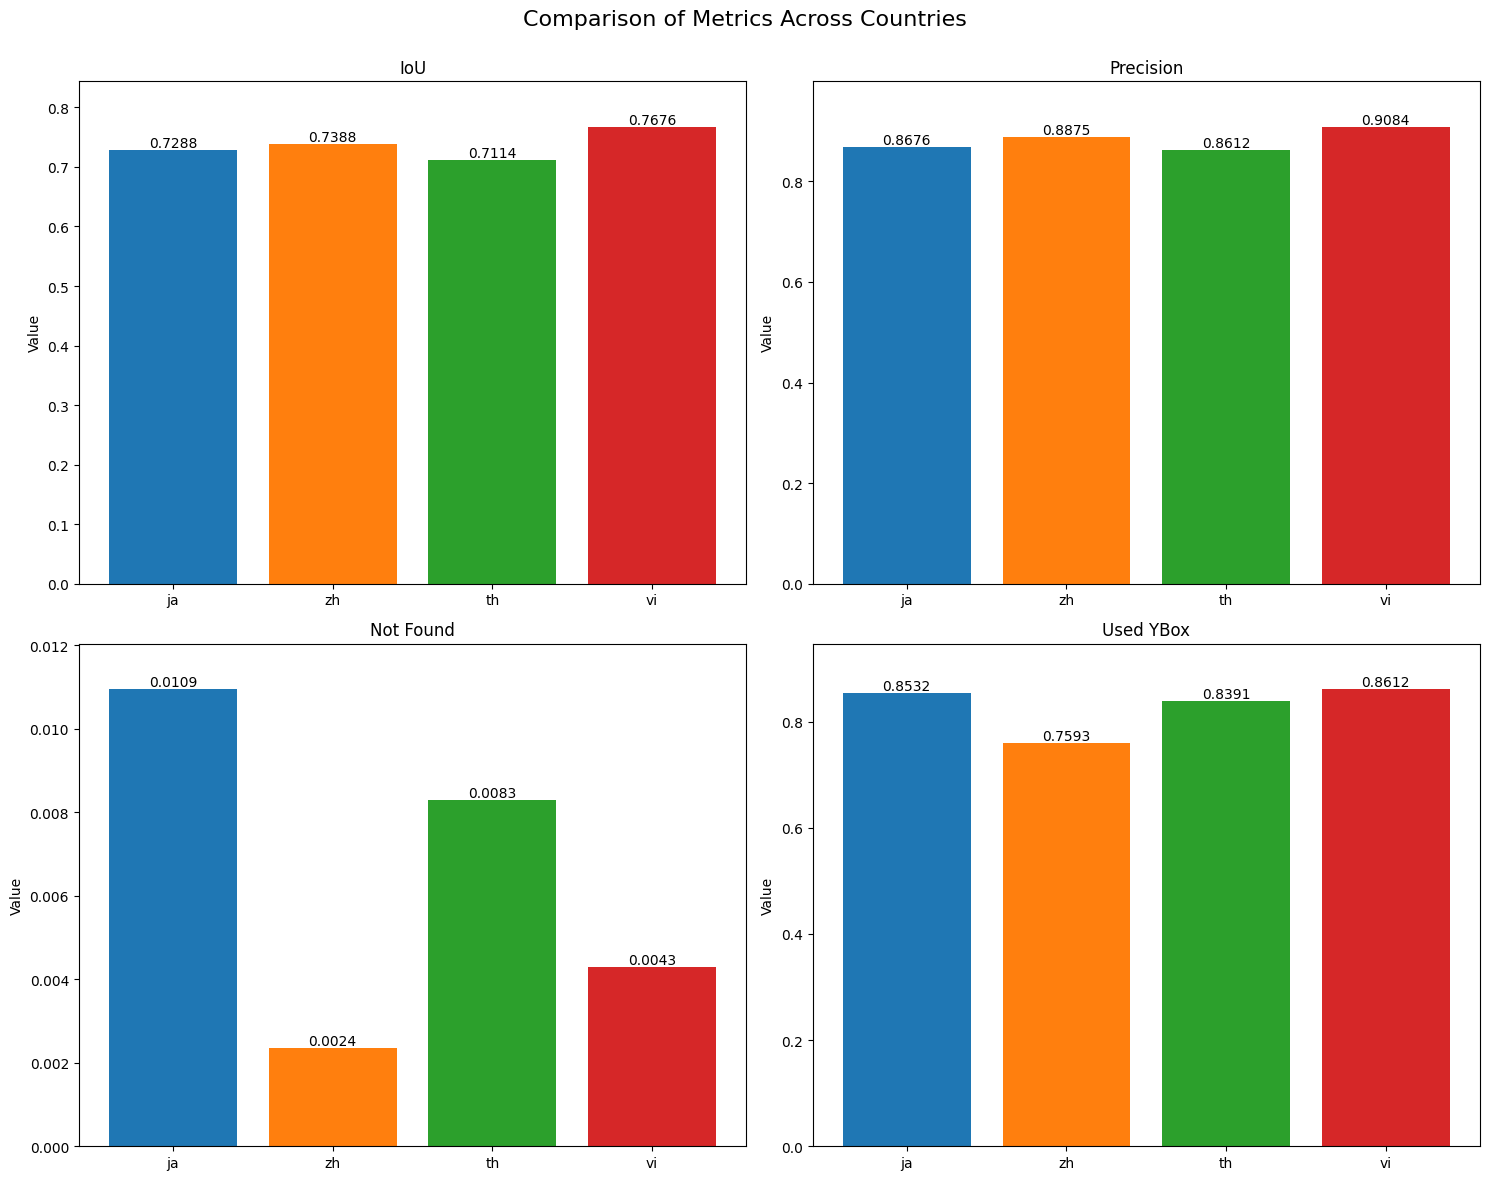

In [20]:
# 막대 그래프의 위치 설정
countries = ['ja', 'zh', 'th', 'vi']
x = np.arange(len(countries))
width = 0.2

# 그래프 생성
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of Metrics Across Countries', fontsize=16)

metrics = [iou_list, precision_list, not_found_list, used_ybox_list]
titles = ['IoU', 'Precision', 'Not Found', 'Used YBox']
# 유명한 색상 팔레트에서 각 나라별 색상 지정
colors = {
    'ja': '#1f77b4',  # 일본 - 블루
    'zh': '#ff7f0e',  # 중국 - 오렌지
    'th': '#2ca02c',  # 태국 - 그린
    'vi': '#d62728'   # 베트남 - 레드
}

for i, (ax, metric, title) in enumerate(zip(axs.flat, metrics, titles)):
    bars = ax.bar(countries, metric, color=[colors[country] for country in countries])
    ax.set_title(title)
    ax.set_ylim(0, sorted(metric)[-1] * 1.1)  # 최대값의 110%로 y축 설정
    
    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', rotation=0)

    # y축 레이블 설정
    ax.set_ylabel('Value')

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # 전체 제목과 서브플롯 사이 간격 조정
plt.show()